# Reinforcement learning velocity control environment

#### Description

> The vehicle's task is to start from an initial position and speed and move towards a goal in a straight line, modifying its speed in order to not invade a person's personal space.

The vehicle state ($s^v$) is given by its position and velocity constrained to the y-axis.
The vehicle detects a human and stores 4 sequential positions to generate an observation.
These positions are points ($\mathbf{P}$) in the plane recorded at arbitrary time intervals $\Delta t$.
While the human velocity ($\dot{p}^h$) can be obtained from the positions and the elapsed time.

\begin{array}{|c|c|c|}\hline
Description              & Symbol   & Content \\ \hline
\mbox{Vehicle state}     & s^v      & \{p_y^v, \dot{p}_y^v\} \\ \hline
\mbox{Human state}       & s^h      & \{p_x^h, p_y^h, \dot{p}^h\} \\ \hline
\mbox{Observation space} & \mathcal{O} & \{̇\mathbf{P}_t^h,\mathbf{P}_{t+1}^h,\mathbf{P}_{t+2}^h,\mathbf{P}_{t+3}^h\}\\ \hline
\mbox{Action space}      & \mathcal{A} & \{\alpha_+, \alpha_{-} \} \\ \hline
\end{array}

Where $\mathcal{O}\in \Re^8$ and $\mathcal{A}\in \Re^2$. \\

The action $\alpha$ is a control variable that updates the current velocity.
\begin{align}
\dot{p}_y^v(t+1) &= \alpha \dot{p}_y^v(t)
\end{align}

The reward ($R$) is obtained by:
\begin{equation}
R = 
\left\{
    \begin{array}{lr}
      &r_g(s^v) + r_h(s^h) &\text{if } |\mathbf{P}^h - \mathbf{P}^v|^2 \geq l^2\\
      &r_g(s^v) &\text{else }
    \end{array}
\right\}
\end{equation}

where $l = 1 + \beta \dot{p}^h$. \\

The vehicle receives a reward $r_g$ that increases as it gets closer to the goal. 
\begin{align}
r_g = \frac{1}{|\mathbf{P}^g - \mathbf{P}^v|+1}
\end{align}
While it receives a penalty when it approaches the human 
\begin{align}
r_h = -\frac{l}{|\mathbf{P}^h - \mathbf{P}^v|}
\end{align}

<figure>
<center>
<img src='https://github.com/JHermosillaD/Reinforcement_learning/blob/main/environment_simulator_V1/imgs/reward.png?raw=true' />
<figcaption>Rewards obtained in an instant of time, when $s^h = \{3,5,1.4\}$ and the goal is at $\mathbf{P}^g(8,-7.5)$. </figcaption></center>
</figure>

The end of an episode is defined by the following terminal states:
  * The vehicle reaches the goal, i.e. $|\mathbf{P}^g - \mathbf{P}^v| \approx 0$
  * The vehicle invades personal space, i.e. $|\mathbf{P}^h - \mathbf{P}^v| < l^2$
  * The vehicle is moving backwards, i.e. $\dot{p}^h < 0$


#### Auxiliar functions

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from IPython.display import HTML
from matplotlib import animation
import matplotlib.pyplot as plt
from collections import deque
from scipy.special import softmax
from gym import Env, spaces
import numpy as np
import graphviz
import random
import keras
import math
import cv2
import io

In [ ]:
def checkpoint(x,y,cx,cy,r):
  p = (x-cx)**2 + (y-cy)**2
  if (p > r**2):
    return True

In [ ]:
def distance(x,y,x_v,y_v):
  return np.sqrt((x-x_v)**2 + (y-y_v)**2)

In [ ]:
def reward_h(x,y,x_h,y_h,v):
  r = - (1+2*v)/distance(x_h,y_h,x,y)
  return r

In [ ]:
def RL_theta(x):
    if (x == -5):
        return random.choice([random.uniform(0, math.pi/2), random.uniform(3*math.pi/2, 2*math.pi)])
    elif (x == 5):
        return random.uniform(math.pi, 3*math.pi/2)

In [ ]:
def T_theta(y):
    return random.uniform(math.pi, 2*math.pi)

In [ ]:
def getImage(path):
  return OffsetImage(plt.imread(path, format="png"), zoom=0.15) 

In [ ]:
def getFig_toArray(fig, dpi=250):
  buf = io.BytesIO()
  fig.savefig(buf, format="png", dpi=dpi)
  buf.seek(0)
  img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
  buf.close()
  img = cv2.imdecode(img_arr, 1)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

### Environment

In [ ]:
class TC_environment(Env):
    def __init__(self):
        self.observations = 4                                                   # O-dimensionality
        self.max_step_size = 0.35                                                # Maximum pedestrian step length
        self.deltaT = 1                                                         # Elapsed time in seconds
        self.width = 8                                                          # Road width
        self.hight = 8                                                          # Road higth
        self.episode_path = []                                                    
        self.car_init_pos = -self.hight/2                                        
        self.car_init_vel = 0.4                                                 
        self.car_state = [self.car_init_pos, self.car_init_vel]                 # Car state
        self.goal = [0, self.hight/2]                                           # Terminal state      
        self.action_space = spaces.Discrete(2) # A = {v+, v-}                   # Action space

    def human_state_generator(self):
        choice = random.choice([0, 1])
        if (choice == 0):                      # RL 
            y_random = random.uniform(-self.hight/4, self.hight/4)
            x_random = random.choice([-self.width/2, self.width/2])
            if (x_random == -self.width/2):
                theta_random = random.choice([random.uniform(0, math.pi/4), random.uniform(7*math.pi/4, 2*math.pi)])
            elif (x_random == self.width/2):
                theta_random = random.uniform(5*math.pi/4, 7*math.pi/4)

        elif (choice == 1):                    # T
            y_random = self.width/2
            x_random = random.uniform(-self.width/4, self.width/4)
            theta_random = random.uniform(5*math.pi/4, 7*math.pi/4)
        return (x_random, y_random, theta_random)    

    def reset(self):                                                            # Function to generate new episode
        increments = []
        self.car_state[0] = self.car_init_pos                                   # Reset
        self.car_state[1] = self.car_init_vel                                    # car state
        step_size = random.uniform(0.1, self.max_step_size)                     # Episode step size
        #x_random = random.uniform(-self.width/4, self.width/4)                  
        #y_random = random.uniform(-self.hight/4, self.hight/4)  #self.hight/2
        #theta = random.uniform(0, 3.1416) #random.uniform(4.45059, 4.97419)                                # Initial pedestrian direction
        x_random, y_random, theta = self.human_state_generator()

        init_pos = (x_random, y_random)                                         # Initial pedestrian position
        self.episode_path = []
        self.episode_path.append(init_pos)
        for i in range(0,self.observations):
            increments.append((step_size*np.cos(theta), step_size*np.sin(theta)))

        for i in range(0,self.observations-1):
            listp = []
            listp.append(self.episode_path[i])
            listp.append(increments[i])
            self.episode_path.append(tuple([sum(tup) for tup in zip(*listp)]))

        return self.episode_path                                                # Pedestrian episode path

    def select_action(self, action):                                            # Function to apply action
        if (action == 0):
            self.car_state[1] += 0.15
        if (action == 1):
            self.car_state[1] -= 0.15    

    def step(self, action):                                                     # Function to feedback episode 
        A = self.episode_path[3][1] - self.episode_path[0][1]                   # Total Y observation increment
        B = self.episode_path[3][0] - self.episode_path[0][0]                   # Total X observation increment
        x_new_increment = B/(self.observations-1)                               # X increment
        y_new_increment = A/(self.observations-1)                               # Y increment
        new_init_pos = (self.episode_path[3][0] + x_new_increment, self.episode_path[3][1] + y_new_increment) 
        increments = []
        new_episode_path = []                                                   # New observation path
        new_episode_path.append(new_init_pos)                                       
        for i in range(0,self.observations-1):
            increments.append((x_new_increment, y_new_increment))

        for i in range(0,self.observations-1):
            listp = []
            listp.append(new_episode_path[i])
            listp.append(increments[i])
            new_episode_path.append(tuple([sum(tup) for tup in zip(*listp)]))

        distance_to_h = distance(new_episode_path[3][0],new_episode_path[3][1],0,self.car_state[0])
        distance_to_g = distance(0,self.car_state[0],self.goal[0],self.goal[1])  
        l = 1 + 0.25*abs(self.car_state[1])  
        #print("Y: %2f, V: %2f, d_g: %2f, d_h: %2f, l: %2f" % (self.car_state[0],self.car_state[1],distance_to_g, distance_to_h, l))
        self.episode_path = new_episode_path    
        self.select_action(action)
        self.car_state[0] = self.car_state[0] + self.car_state[1]*self.deltaT
        r_h = reward_h(new_episode_path[3][0],new_episode_path[3][1],0,self.car_state[0],self.car_state[1])
        reward = 0
        epsilon_distance = 0.25
        done = False
        if (distance_to_h > l):
          reward += r_h
        if (distance_to_g <= epsilon_distance):
          done = True
        elif (distance_to_h <= l):
          reward += 2*r_h
          done = True
        elif (self.car_state[1] <= 0):
          done = True
        elif ((new_episode_path[3][1] > self.hight) or (new_episode_path[3][1] < -self.hight)):
          done = True
        elif ((new_episode_path[3][0] > self.width) or (new_episode_path[3][0] < -self.width)):
          done = True
        return new_episode_path, reward, done
   
    def custom_render(self, path):
        fig, ax = plt.subplots()
        fig.subplots_adjust(0,0,1,1)
        ax.axis('off')
        margin = 1
        plt.plot([0,0], [-100,100], linestyle='--', linewidth=1, color='black')
        plt.axvline(x= self.width/4, c="black")
        plt.axvline(x=-self.width/4, c="black")
        plt.xlim([-self.width/2 -margin, self.width/2 +margin])
        plt.ylim([-self.hight/2 -margin, self.hight/2 +margin])
        plt.rcParams["figure.figsize"] = (5,5)
        car = AnnotationBbox( getImage('https://github.com/JHermosillaD/Reinforcement_learning/blob/main/environment_simulator_V1/imgs/car.png?raw=true'), (0, self.car_state[0] ), frameon=False)
        ax.add_artist(car)
        equis = []
        yes = []
        for i in path:
            pedestrian = AnnotationBbox( getImage('https://github.com/JHermosillaD/Reinforcement_learning/blob/main/environment_simulator_V1/imgs/pedestrian.png?raw=true'), i , frameon=False)
            equis.append(i[0])
            yes.append(i[1])
            ax.add_artist(pedestrian)
        plt.plot(equis, yes, linestyle='--', linewidth=1, color='black')
        plot_array = getFig_toArray(fig)
        plt.close()
        return plot_array

### Deep Q-learning

#### Plot network

In [ ]:
def plot_DQN(model):
    input_layer = 0;
    hidden_layers_nr = 0;
    layer_types = [];
    hidden_layers = [];
    output_layer = 0;

    for layer in model.layers:
        if(layer == model.layers[0]):
            input_layer = int(str(layer.input_shape).split(",")[1][1:-1]);
            hidden_layers_nr += 1;
            if (type(layer) == keras.layers.core.Dense):
                hidden_layers.append(int(str(layer.output_shape).split(",")[1][1:-1]));
                layer_types.append("Dense");
            else:
                hidden_layers.append(1);
        else:
            if(layer == model.layers[-1]):
                output_layer = int(str(layer.output_shape).split(",")[1][1:-1]);
            else:
                hidden_layers_nr += 1;
                if (type(layer) == keras.layers.core.Dense):
                    hidden_layers.append(int(str(layer.output_shape).split(",")[1][1:-1]));
                    layer_types.append("Dense");
                else:
                    hidden_layers.append(1);

        last_layer_nodes = input_layer;
        nodes_up = input_layer;
        if(type(model.layers[0]) != keras.layers.core.Dense):
            last_layer_nodes = 1;
            nodes_up = 1;
            input_layer = 1;

        g = graphviz.Digraph('g');
        n = 0;
        g.graph_attr.update(splines="line", nodesep='0.5', ranksep='4.0', rankdir='TB', size="10", fontsize='25pt');
        with g.subgraph(name='cluster_input') as c:
            if(type(model.layers[0]) == keras.layers.core.Dense):
                the_label = 'Input states';
                c.attr(color='white')
                for i in range(0, input_layer):
                    n += 1;
                    c.node(str(n));
                    c.attr(label=the_label, rank='same');
                    c.node_attr.update(color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle");
            else:
                raise ValueError("ANN Visualizer: Layer not supported for visualizing");
        for i in range(0, hidden_layers_nr):
            with g.subgraph(name="cluster_"+str(i+1)) as c:
                if (layer_types[i] == "Dense"):
                    c.attr(color='white', rank='same', labeljust="right", labelloc="c");
                    for j in range(0, hidden_layers[i]):
                        n += 1;
                        c.node(str(n), shape="circle", style="filled", color="#3498db", fontcolor="#3498db");
                        for h in range(nodes_up - last_layer_nodes + 1 , nodes_up + 1):
                            g.edge(str(h), str(n));
                    last_layer_nodes = hidden_layers[i];
                    nodes_up += hidden_layers[i];

        with g.subgraph(name='cluster_output') as c:
            if (type(model.layers[-1]) == keras.layers.core.Dense):
                c.attr(color='white', rank='same', labeljust="1");
                for i in range(1, output_layer+1):
                    n += 1;
                    c.node(str(n), shape="circle", style="filled", color="#e74c3c", fontcolor="#e74c3c");
                    for h in range(nodes_up - last_layer_nodes + 1 , nodes_up + 1):
                        g.edge(str(h), str(n));
                c.attr(label='Action states', labelloc="b")
                c.node_attr.update(color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle");

        g.attr(arrowShape="none");
        g.edge_attr.update(arrowhead='none', color="#707070", penwidth='0.5');
    return g

#### Model

In [ ]:
class DQN:
    def __init__(self, env, hidden_size=16):
        self.state_size = 8
        self.action_size = env.action_space.n
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.Dense(hidden_size, activation="relu", input_dim=self.state_size))
        self.model.add(keras.layers.Dense(hidden_size, activation="relu"))
        self.model.add(keras.layers.Dense(self.action_size, activation="linear"))
        self.model.compile(loss="mse", optimizer="Adam")

    def __call__(self,s):
        s = np.reshape(s, [1, self.state_size])
        a = self.model.predict(s)
        a = np.reshape(a,[self.action_size])
        return a

#### Replay memory buffer

In [ ]:
class Memory:
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        idx = np.random.choice(len(self.buffer),
                               size=batch_size,
                               replace=False)
        return [self.buffer[ii] for ii in idx]

In [ ]:
def create_experience(Q,replaybuffer,eps=0.1,max_episodes=1000):
    average_return = 0
    for i in range(max_episodes):
        state = env.reset()
        done = False
        while not done:
            average_return += 1
            if eps>np.random.rand():
                action = env.action_space.sample()
            else:
                action = np.argmax(Q(state))
            next_state, reward, done = env.step(action)
            replaybuffer.add((state,action,reward,next_state,done))
            state = next_state
            if done: 
                break
    avg_return = average_return/max_episodes
    return avg_return

#### Epsilon-greedy approach

In [ ]:
def eps_decay(i, start=1.0, stop=0.01, annealing_stop=1000):
    inew = min(i,annealing_stop)
    return (start * (annealing_stop - inew) + stop * inew) / annealing_stop

### DQN initialization

In [ ]:
env = TC_environment()
Q = DQN(env,hidden_size=11)

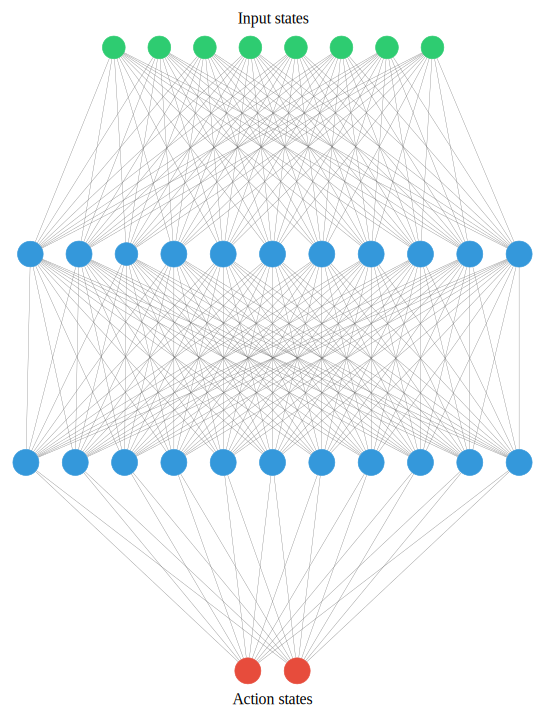

In [ ]:
plot_DQN(Q.model)

### Environment simulation

In [ ]:
def env_simulation(env):
    fig, ax = plt.subplots()
    fig.subplots_adjust(0,0,1,1)
    ax.axis('off')
    state = env.reset()
    episode = []
    max_steps = 10
    done = False
    steps = 0
    while not done: 
        im = ax.imshow(env.custom_render(state), aspect='auto')
        episode.append([im])
        steps += 1
        if (0.1 > np.random.rand()):
            action = env.action_space.sample()
        else:
            action = np.argmax(Q(state))
        next_state, reward, done = env.step(action)
        state = next_state
        if done: 
            print("steps: ", steps, done)
            break
    plt.close()
    return fig, episode

In [ ]:
fig, episode = env_simulation(env)
experiment = animation.ArtistAnimation(fig, episode, interval=500, repeat=30, blit=True)
HTML(experiment.to_html5_video())

In [ ]:
TargetQ = DQN(env,hidden_size=11)
TargetQ.model.set_weights(Q.model.get_weights())

In [ ]:
train_episodes = 800
gamma = 0.99       
explore_start = 0.9
explore_stop = 0.01
annealing_stop = train_episodes/2     

FixedBufferPercentage = 10
ReplayBufferSize = 1000
batch_size = 11
Theta=np.logspace(-1,1,train_episodes)

replaybuffer = Memory(int(ReplayBufferSize * (1-FixedBufferPercentage/100)))
create_experience(Q,replaybuffer,eps=1.0,max_episodes=900)
fixedbuffer = Memory(int(ReplayBufferSize * (FixedBufferPercentage/100)))
create_experience(Q,fixedbuffer,eps=1.0,max_episodes=100)

print("size replay buffer = ", len(replaybuffer.buffer))
print("size fixed buffer =", len(fixedbuffer.buffer))

totalbuffer = Memory(ReplayBufferSize) 
TargetQ = DQN(env,hidden_size=11)
TargetQ.model.set_weights(Q.model.get_weights())

learning_curve=[] 
acum_reward = []
acum_rw = 0

In [ ]:
for ep in range(1,train_episodes+1):
    state = env.reset()
    flat_state = list(sum(state, ()))
    eps = eps_decay(ep,explore_start,explore_stop,annealing_stop)
    total_return = 0
    done = False 
    #max_steps = 10
    while not done: 
    #for n_step in range(max_steps):
        actionarray = Q(flat_state)
        theta=Theta[ep-1]
        p=softmax(actionarray*theta)
        action = np.random.choice(2,p=p)
        
        next_state, reward, done = env.step(action)
        if done: 
            break
        flat_next_state = list(sum(next_state, ()))
        total_return += reward
        replaybuffer.add((state,action,reward,flat_next_state,done))
        flat_state = flat_next_state 
        
        inputs = np.zeros((batch_size, 8))
        targets = np.zeros((batch_size, env.action_space.n))
        
        totalbuffer.buffer += replaybuffer.buffer
        totalbuffer.buffer += fixedbuffer.buffer
        minibatch = totalbuffer.sample(batch_size)
        for i, (state_b, action_b, reward_b, next_state_b, done_b) in enumerate(minibatch):

            flat_state_b = np.array(list(sum(state_b, ())))
            if (all(isinstance(item, tuple) for item in next_state_b)) == True:
              flat_next_state_b = np.array(list(sum(next_state_b, ())))
            else: 
              flat_next_state_b = next_state_b

            inputs[i:i+1] = flat_state_b
            if done_b:
                target = reward_b
            else:
                a_q = np.argmax(Q(flat_next_state_b)) 
                target = reward_b + gamma * TargetQ(flat_next_state_b)[a_q] 
            targets[i] = Q(flat_state_b)
            targets[i][action_b] = target 
        Q.model.fit(inputs, targets, epochs=1, verbose=0)
    acum_rw += total_return 
    if ep%10==0:
        #print("Episode ",ep, "average return = ", total_return, "eps =",eps)
        TargetQ.model.set_weights(Q.model.get_weights())
    learning_curve.append(total_return)
    acum_reward.append(acum_rw)

In [ ]:
plt.plot(learning_curve)